In [1]:
import logging
import sys
import tensorflow as tf
from utlis.io_helper import OsPath
import os
from utlis.config_helper import NetConfig, PPOConfig, PlatformerConfig, RunnerConfig

from Networks.obervation_preprocessors.cnn_obs_preprocessor import CnnObservationsPreprocessor
from Networks.reward_preprocessor.intrinsic_curiosity_model import IntrinsicCuriosityModel

%matplotlib inline

In [2]:
config_path = OsPath("./configs/curiosity_small_extrinsic_reward_grayscale.yaml")
config = PlatformerConfig.from_file(config_path)

log_folder = OsPath(f"data/networks/")

obs_spec = [84, 84, 3]

# Ppo Preprocessor

In [3]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(obs_spec, name="ppoInput"))

for l in config.ppo.preprocessing_layers:
    model.add(l)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ppoConv2D_1 (Conv2D)         (None, 20, 20, 16)        3088      
_________________________________________________________________
ppoConv2D_2 (Conv2D)         (None, 9, 9, 32)          8224      
_________________________________________________________________
ppoConv2D_3 (Conv2D)         (None, 7, 7, 32)          9248      
_________________________________________________________________
ppoFlatten (Flatten)         (None, 1568)              0         
Total params: 20,560
Trainable params: 20,560
Non-trainable params: 0
_________________________________________________________________


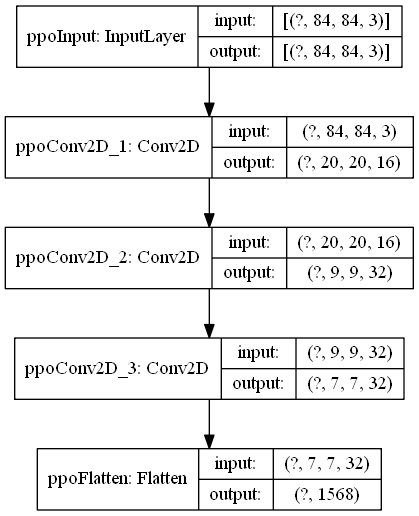

In [4]:
tf.keras.utils.plot_model(model, str(log_folder + "ppo_preprocessing_layers.png"), show_shapes=True, expand_nested=True)

In [5]:
for l in config.ppo.preprocessing_layers:
    conf = l.get_config()
    if isinstance(l, tf.keras.layers.Conv2D):
        print('conv2D', conf['filters'], conf['kernel_size'], conf['strides'], conf['padding'], conf['activation'])
    else:
        print(conf)

conv2D 16 (8, 8) (4, 4) valid relu
conv2D 32 (4, 4) (2, 2) valid relu
conv2D 32 (3, 3) (1, 1) valid relu
{'name': 'ppoFlatten', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}


In [17]:
cnnObservationsPreprocessor = CnnObservationsPreprocessor(obs_spec, config.cnn_obs_preprocessor.layers)
reward_predictor = IntrinsicCuriosityModel(
    cnnObservationsPreprocessor, 
    action_len=2, 
    dense_specs_forward_model=config.rnd_reward_preprocessor.dense_spec_predictor,
    dense_specs_invers_model=config.rnd_reward_preprocessor.dense_spec_target,
    curiosity_normalizer=config.rnd_reward_preprocessor.curiosity_normalizer)

tf.keras.utils.plot_model(reward_predictor.forward_model, str(log_folder + "forward_model.png"), show_shapes=True)
tf.keras.utils.plot_model(reward_predictor.inverse_model, str(log_folder + "invers_model.png"), show_shapes=True)
# tf.keras.utils.plot_model(reward_predictor.icm_model, str(log_folder + "icm_model.png"), show_shapes=True)

dot = tf.keras.utils.model_to_dot(reward_predictor.icm_model, show_shapes=True, expand_nested=True)
svg_file = log_folder + "icm_model.svg"

with svg_file.open_write('b') as f:
    f.write(dot.create_svg())

<class 'bytes'>


TypeError: write() argument must be str, not bytes